In [1]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
base = ResNet50V2(False)

In [3]:
base.trainable = False
inputs = L.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = L.GlobalAveragePooling2D()(x)
outputs = L.Dense(5)(x)

In [4]:
model = Model(inputs, outputs)
model.compile(Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=[CategoricalAccuracy()])
model.save_weights('checkpoints/resnet50v2_default.h5')

In [5]:
df = pd.read_csv('data/train.csv')
df = df[~df['path'].str.endswith('.gif')]

In [6]:
histories = []

for i, (trix, tsix) in enumerate(StratifiedKFold(n_splits=4).split(df, df['class'])):
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        width_shift_range=[-60, 60], height_shift_range=[-60, 60],
        horizontal_flip=True, vertical_flip=True,
        zoom_range=[0.5, 1.5]
    ).flow_from_dataframe(df.iloc[trix], x_col='path', target_size=(224, 224), validate_filenames=False)
    test_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_dataframe(df.iloc[tsix], x_col='path', target_size=(224, 224), validate_filenames=False)
    model.load_weights('checkpoints/resnet50v2_default.h5')
    h = model.fit(
        train_gen, validation_data=test_gen, epochs=100,
        callbacks=[EarlyStopping(min_delta=0.01, patience=30, restore_best_weights=True)],
        verbose=2
    )
    model.save(f'checkpoints/resnet50v2_fold_{i}.h5')
    pd.DataFrame.from_dict(h.history).to_csv(f'checkpoints/resnet50v2_fold_{i}_history.csv', index=False)

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.
Epoch 1/100
10/10 - 13s - loss: 1.5525 - categorical_accuracy: 0.3183 - val_loss: 1.0761 - val_categorical_accuracy: 0.6082


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2/100
10/10 - 9s - loss: 0.9381 - categorical_accuracy: 0.6851 - val_loss: 0.6831 - val_categorical_accuracy: 0.7732
Epoch 3/100
10/10 - 9s - loss: 0.7573 - categorical_accuracy: 0.7093 - val_loss: 0.5303 - val_categorical_accuracy: 0.8144
Epoch 4/100
10/10 - 9s - loss: 0.5523 - categorical_accuracy: 0.8028 - val_loss: 0.4614 - val_categorical_accuracy: 0.8351
Epoch 5/100
10/10 - 9s - loss: 0.5172 - categorical_accuracy: 0.8201 - val_loss: 0.4196 - val_categorical_accuracy: 0.8247
Epoch 6/100
10/10 - 9s - loss: 0.4727 - categorical_accuracy: 0.8443 - val_loss: 0.4093 - val_categorical_accuracy: 0.8454
Epoch 7/100
10/10 - 9s - loss: 0.4436 - categorical_accuracy: 0.8651 - val_loss: 0.3805 - val_categorical_accuracy: 0.8660
Epoch 8/100
10/10 - 9s - loss: 0.4264 - categorical_accuracy: 0.8408 - val_loss: 0.3925 - val_categorical_accuracy: 0.8660
Epoch 9/100
10/10 - 9s - loss: 0.4425 - categorical_accuracy: 0.8616 - val_loss: 0.3466 - val_categorical_accuracy: 0.8351
Epoch 10/100
10/

/home/jaidevd/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
10/10 - 9s - loss: 1.5250 - categorical_accuracy: 0.3426 - val_loss: 0.9307 - val_categorical_accuracy: 0.6392
Epoch 2/100
10/10 - 9s - loss: 0.7877 - categorical_accuracy: 0.6713 - val_loss: 0.6440 - val_categorical_accuracy: 0.7732
Epoch 3/100
10/10 - 9s - loss: 0.5734 - categorical_accuracy: 0.7889 - val_loss: 0.4865 - val_categorical_accuracy: 0.8144
Epoch 4/100
10/10 - 9s - loss: 0.4502 - categorical_accuracy: 0.8304 - val_loss: 0.4797 - val_categorical_accuracy: 0.8351
Epoch 5/100
10/10 - 9s - loss: 0.4508 - categorical_accuracy: 0.8478 - val_loss: 0.4383 - val_categorical_accuracy: 0.8660
Epoch 6/100
10/10 - 9s - loss: 0.4050 - categorical_accuracy: 0.8443 - val_loss: 0.4077 - val_categorical_accuracy: 0.8660
Epoch 7/100
10/10 - 9s - loss: 0.3446 - categorical_accuracy: 0.8685 - val_loss: 0.3999 - val_categorical_accuracy: 0.8660
Epoch 8/100
10/10 - 9s - loss: 0.3530 - categorical_accuracy: 0.8720 - val_loss: 0.4098 - val_categorical_accuracy: 0.8763
Epoch 9/100
10/1

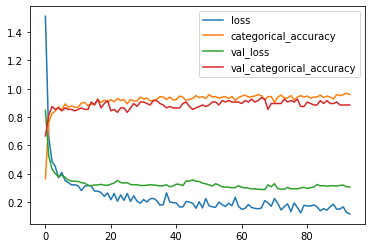

In [8]:
for k, v in h.history.items():
    plt.plot(v, label=k)
plt.legend()